In [ ]:
import os
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import models

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("generative_inpainting_pytorch")
from generative_inpainting_pytorch.model.networks import Generator
from generative_inpainting_pytorch.utils.tools import (
    get_config,
    random_bbox,
    mask_image,
    is_image_file,
    default_loader,
    normalize,
    get_model_list,
)

In [ ]:
config_file = "generative_inpainting_pytorch/configs/config.yaml"
config = get_config(config_file)

## segmentation

In [84]:
PASCAL_VOC_LABELS = {
    0: "background",
    1: "aeroplane",
    2: "bicycle",
    3: "bird",
    4: "boat",
    5: "bottle",
    6: "bus",
    7: "car",
    8: "cat",
    9: "chair",
    10: "cow",
    11: "diningtable",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "pottedplant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tvmonitor",
}

# Load a pre-trained DeepLabV3 model
# `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights
model = models.segmentation.deeplabv3_resnet101(
    weights="DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1"
)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

resize = transforms.Resize(config["image_shape"][:-1])
seg_preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [85]:
image_dir = "input_imgs"
images = [
    "0001TP_009210.png",
    "0006R0_f02610.png",
]
original_sizes = []

original_imgs = []
input_imgs = []
input_tensors = []
for i in range(len(images)):
    input_image = Image.open(os.path.join(image_dir, images[i]))
    original_sizes.append(input_image.size)
    original_imgs.append(input_image)
    resized_image = resize(input_image)
    input_imgs.append(resized_image)
    processed_tensor = seg_preprocess(resized_image)
    input_tensors.append(processed_tensor)

input_batch = torch.stack(input_tensors).to(device)

with torch.no_grad():
    output = model(input_batch)["out"]
output_predictions = output.argmax(1)  # Get predictions for each image in the batch

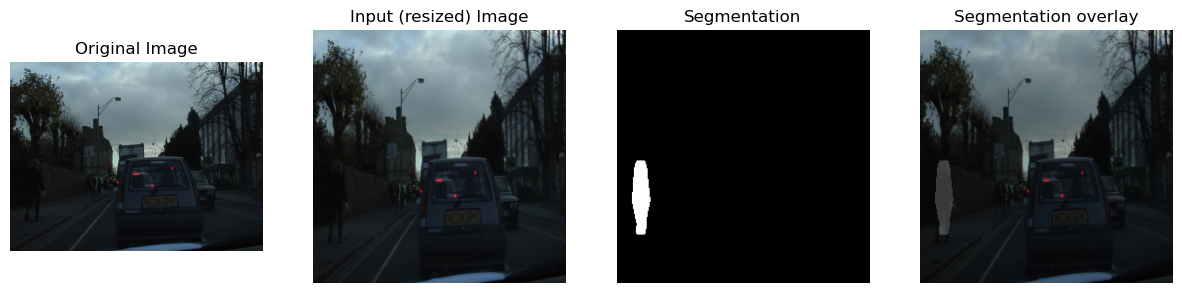

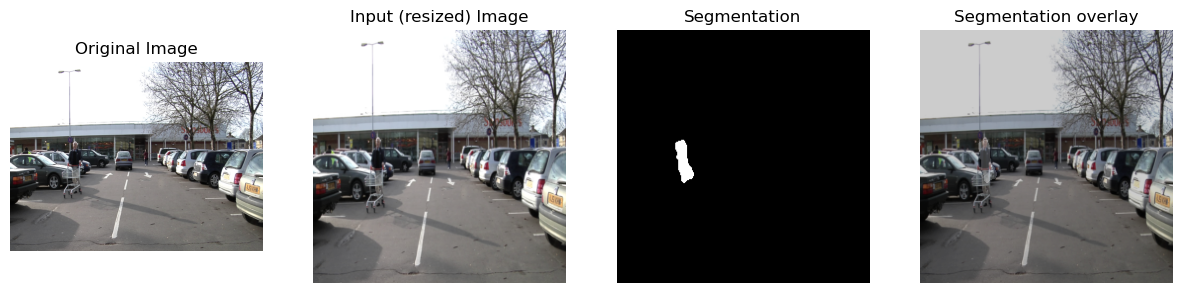

In [100]:
def get_masks_by_class(predictions, target_class=15):
    NUM_CLASSES = 21
    label_colors = torch.zeros((NUM_CLASSES, 1)).to(device)
    label_colors[target_class] = 1  # Class Person change to white
    return label_colors[predictions]


segmentations_tensor = get_masks_by_class(output_predictions, target_class=15)
segmentations = segmentations_tensor.cpu().numpy()

for i, segmentation in enumerate(segmentations):

    fig, ax = plt.subplots(1, 4, figsize=(15, 6))
    ax[0].imshow(original_imgs[i])
    ax[0].set_title(f"Original Image")
    ax[0].axis("off")
    ax[1].imshow(input_imgs[i])
    ax[1].set_title(f"Input (resized) Image")
    ax[1].axis("off")
    ax[2].imshow(segmentation, cmap="gray")
    ax[2].set_title(f"Segmentation")
    ax[2].axis("off")
    ax[3].imshow(input_imgs[i])
    ax[3].imshow(segmentation, alpha=0.2, cmap="gray")
    ax[3].set_title(f"Segmentation overlay")
    ax[3].axis("off")

    plt.show()

## generative inpainting

In [110]:
def predict(images, masks, config, default_seed=None, train_iter=0):
    """
    images: tensor of shape (batch_size, 3, H, W)
    masks: tensor of shape (batch_size, 1, H, W)
    """
    # CUDA configuration
    cuda = config["cuda"]
    device_ids = config["gpu_ids"]
    if cuda:
        os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config["gpu_ids"] = device_ids
        cudnn.benchmark = True

    # Set random seed
    if default_seed is None:
        default_seed = random.randint(1, 10000)
    print("Random seed: {}".format(default_seed))
    random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed_all(default_seed)

    checkpoint_path = os.path.join(
                    "generative_inpainting_pytorch",
                    "checkpoints",
                    config["dataset_name"],
                    config["mask_type"] + "_" + config["expname"],
                )
    with torch.no_grad():
        # Define the model
        netG = Generator(config["netG"], cuda, device_ids)
        # Resume weight
        last_model_name = get_model_list(
            checkpoint_path, "gen", iteration=train_iter
        )
        print(last_model_name)
        netG.load_state_dict(torch.load(last_model_name))
        model_iteration = int(last_model_name[-11:-3])
        print(
            "Resume from {} at iteration {}".format(
                checkpoint_path, model_iteration
            )
        )

        if cuda:
            netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
            images = images.cuda()
            masks = masks.cuda()

        # Inference
        x1, x2, offset_flow = netG(images, masks)
        inpainted_result = x2 * masks + images * (1.0 - masks)

    # normalize the inpainted result to [0, 1]
    inpainted_result = inpainted_result.detach().cpu().numpy()
    inpainted_result = (inpainted_result + 1) / 2.0
    return inpainted_result

# TODO: move outside
# preprocess the images
masks = segmentations_tensor.permute(0, 3, 1, 2)
input_tensors = []
for i in range(len(images)):
    input_image_file = os.path.join(image_dir, images[i])
    img = default_loader(input_image_file)
    img = resize(img)
    img = transforms.ToTensor()(img)
    img = normalize(img)
    img = img.to(device) * (1.0 - masks[i])
    input_tensors.append(img)

input_batch = torch.stack(input_tensors).to(device)
res = predict(input_batch, masks, config)

Random seed: 453
generative_inpainting_pytorch\checkpoints\imagenet\hole_benchmark\gen_00430000.pt
Resume from generative_inpainting_pytorch\checkpoints\imagenet\hole_benchmark at iteration 430000


(2, 3, 256, 256)


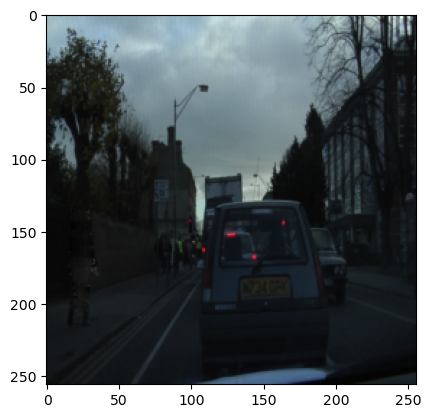

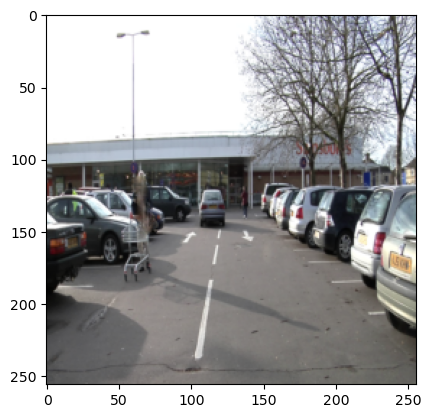

In [111]:
print(res.shape)
for img in res:
    plt.imshow(img.transpose(1, 2, 0))
    plt.show()

In [ ]:

def plot(img_lst, titles):
    _, axes = plt.subplots(1, len(img_lst), figsize=(15, 5))
    assert len(img_lst) == len(titles)
    for i, img in enumerate(img_lst):
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(titles[i])

    plt.show()

Random seed: 1267
Configuration: {'dataset_name': 'imagenet', 'data_with_subfolder': True, 'train_data_path': '/media/ouc/4T_A/datasets/ImageNet/ILSVRC2012_img_train/', 'val_data_path': None, 'resume': None, 'batch_size': 48, 'image_shape': [256, 256, 3], 'mask_shape': [128, 128], 'mask_batch_same': True, 'max_delta_shape': [32, 32], 'margin': [0, 0], 'discounted_mask': True, 'spatial_discounting_gamma': 0.9, 'random_crop': True, 'mask_type': 'hole', 'mosaic_unit_size': 12, 'expname': 'benchmark', 'cuda': True, 'gpu_ids': [0], 'num_workers': 4, 'lr': 0.0001, 'beta1': 0.5, 'beta2': 0.9, 'n_critic': 5, 'niter': 500000, 'print_iter': 100, 'viz_iter': 1000, 'viz_max_out': 16, 'snapshot_save_iter': 5000, 'coarse_l1_alpha': 1.2, 'l1_loss_alpha': 1.2, 'ae_loss_alpha': 1.2, 'global_wgan_loss_alpha': 1.0, 'gan_loss_alpha': 0.001, 'wgan_gp_lambda': 10, 'netG': {'input_dim': 3, 'ngf': 32}, 'netD': {'input_dim': 3, 'ndf': 64}}
generative_inpainting_pytorch\checkpoints\imagenet\hole_benchmark\gen_0

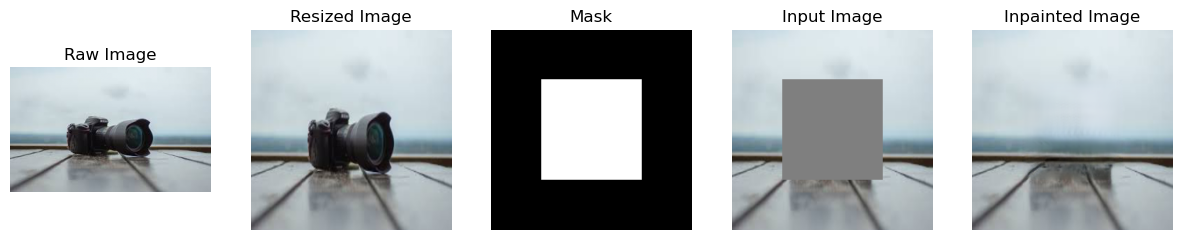

In [11]:
# Image shape: (256, 256, 3)
image_file = "input_imgs/camera.jpg"
mask_file = "generative_inpainting_pytorch/examples/center_mask_256.png"  # empty to use random mask
output_file = "output_imgs/output.png"
config_file = "generative_inpainting_pytorch/configs/config.yaml"

res_imgs = predict(
    image_file, mask_file, output_file=output_file, config_file=config_file
)

plot(res_imgs, ["Raw Image", "Resized Image", "Mask", "Input Image", "Inpainted Image"])

Random seed: 6266
Configuration: {'dataset_name': 'imagenet', 'data_with_subfolder': True, 'train_data_path': '/media/ouc/4T_A/datasets/ImageNet/ILSVRC2012_img_train/', 'val_data_path': None, 'resume': None, 'batch_size': 48, 'image_shape': [256, 256, 3], 'mask_shape': [128, 128], 'mask_batch_same': True, 'max_delta_shape': [32, 32], 'margin': [0, 0], 'discounted_mask': True, 'spatial_discounting_gamma': 0.9, 'random_crop': True, 'mask_type': 'hole', 'mosaic_unit_size': 12, 'expname': 'benchmark', 'cuda': True, 'gpu_ids': [0], 'num_workers': 4, 'lr': 0.0001, 'beta1': 0.5, 'beta2': 0.9, 'n_critic': 5, 'niter': 500000, 'print_iter': 100, 'viz_iter': 1000, 'viz_max_out': 16, 'snapshot_save_iter': 5000, 'coarse_l1_alpha': 1.2, 'l1_loss_alpha': 1.2, 'ae_loss_alpha': 1.2, 'global_wgan_loss_alpha': 1.0, 'gan_loss_alpha': 0.001, 'wgan_gp_lambda': 10, 'netG': {'input_dim': 3, 'ngf': 32}, 'netD': {'input_dim': 3, 'ndf': 64}}
generative_inpainting_pytorch\checkpoints\imagenet\hole_benchmark\gen_0

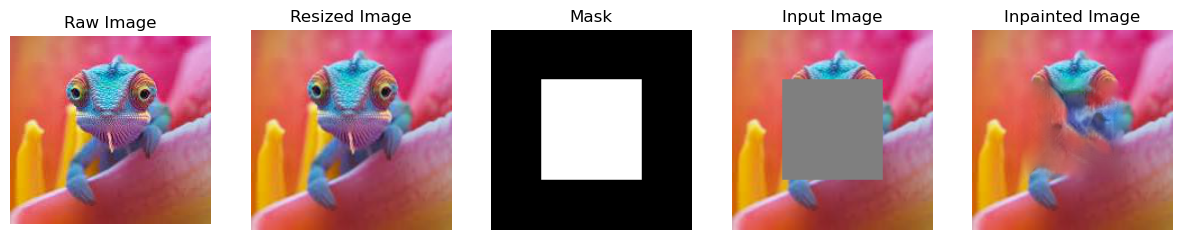

In [5]:
# Image shape: (256, 256, 3)
image_file = "input_imgs/chameleon.jpg"
mask_file = "generative_inpainting_pytorch/examples/center_mask_256.png"  # empty to use random mask
output_file = "output_imgs/output.png"
config_file = "generative_inpainting_pytorch/configs/config.yaml"

res_imgs = predict(
    image_file, mask_file, output_file=output_file, config_file=config_file
)

plot(res_imgs, ["Raw Image", "Resized Image", "Mask", "Input Image", "Inpainted Image"])